# LIBRARIES

In [1]:
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.EEG_Tensorflow_models
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.visualizations.git

  Cloning https://github.com/UN-GCPDS/python-gcpds.EEG_Tensorflow_models to /tmp/pip-req-build-5gw219d_
  Running command git clone --filter=blob:none --quiet https://github.com/UN-GCPDS/python-gcpds.EEG_Tensorflow_models /tmp/pip-req-build-5gw219d_
  Resolved https://github.com/UN-GCPDS/python-gcpds.EEG_Tensorflow_models to commit 975885b1f6814fd5958199919b33e02a6a9aa152
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.4/184.4 kB 1.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.7/230.7 kB 4.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.8 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.7/234.7 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 49.0 MB/s eta 0:00:

In [2]:
!pip install --upgrade tf-keras-vis

In [3]:
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from sklearn.manifold import TSNE
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

2024-08-12 01:40:36.303519: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-12 01:40:36.303647: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-12 01:40:36.494438: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# LOAD DATABASES

In [4]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()  # Load the Fashion MNIST dataset
X_train_full = X_train_full.astype(np.float32) / 255  # Convert training data to float32 and normalize
X_test = X_test.astype(np.float32) / 255  # Convert test data to float32 and normalize
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]  # Split the training data into training and validation sets
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]  # Split the training labels into training and validation sets

4422102/4422102 [==============================] - 0s 0us/step


# FUNCTIONS

In [5]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def show_reconstructions(model, images=X_test, n_images=5):
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    reconstructions = model.predict(images[:n_images])

    for i in range(n_images):
        plt.subplot(2, n_images, i + 1)
        plot_image(images[i].reshape(28, 28))

        plt.subplot(2, n_images, i + 1 + n_images)
        plot_image(reconstructions[i].reshape(28, 28))

def rounded_accuracy(y_true, y_pred):
    y_true_rounded = tf.round(y_true)
    y_pred_rounded = tf.round(y_pred)
    return keras.metrics.binary_accuracy(y_true_rounded, y_pred_rounded)

def plot_history(history):
    epochs = range(1, len(history.history['loss']) + 1)

    plt.figure(figsize=(10, 4))

    # Gráfico de la pérdida de entrenamiento y validación (líneas)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['loss'], label='Training loss')
    plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
   

    # Gráfico de barras para la precisión de entrenamiento y validación
    plt.subplot(1, 2, 2)
    width = 0.4  # Ancho de las barras
    positions = range(len(epochs))
    
    plt.bar(positions, history.history['rounded_accuracy'], width=width, label='Training accuracy')
    plt.bar([p + width for p in positions], history.history['val_rounded_accuracy'], width=width, label='Validation accuracy')

    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks([p + width/2 for p in positions], epochs)  # Centrar etiquetas de las épocas
    plt.legend()

    plt.tight_layout()
    plt.show()
    

def plot_training_history(history):
    epochs = range(1, len(history.history['reconstruction_loss']) + 1)
    
    # Create a figure with subplots
    plt.figure(figsize=(12, 6))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['reconstruction_loss'], label='Reconstruction Loss')
    plt.plot(epochs, history.history['kl_loss'], label='KL Loss')
    plt.plot(epochs, history.history['total_loss'], label='Total Loss')
    plt.title('Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy as bar graphs
    plt.subplot(1, 2, 2)
    width = 0.4  # Width of the bars
    positions = range(len(epochs))
    
    plt.bar(positions, history.history['rounded_accuracy'], width=width, label='Train Accuracy')
    plt.bar([p + width for p in positions], history.history['val_rounded_accuracy'], width=width, label='Validation Accuracy')
    
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks([p + width/2 for p in positions], epochs)  # Center epoch labels
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)  # Defino el número de columnas, o uso la longitud de las imágenes si no se especifica
    n_rows = (len(images) - 1) // n_cols + 1  # Calculo el número de filas necesario

    if images.shape[-1] == 1:                 # Si las imágenes tienen un solo canal (grayscale)
        images = np.squeeze(images, axis=-1)  # Elimino la dimensión del canal
    plt.figure(figsize=(n_cols, n_rows))  # Creo una figura con el tamaño adecuado

    for index, image in enumerate(images):  # Recorro cada imagen
        plt.subplot(n_rows, n_cols, index + 1)  # Creo un subplot para la imagen actual
        plt.imshow(image, cmap="binary")  # Muestro la imagen en escala de grises
        plt.axis("off")  # Oculto los ejes

    plt.show()  # Muestra la figura con todas las imágenes
    

def train_gan(gan, dataset, batch_size, codings_size, n_epochs=5):
    generator, discriminator = gan.layers  # Obtengo el generador y el discriminador del GAN
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))  # Muestro la época actual

        for i_, X_batch in enumerate(dataset):  # Recorro el dataset por lotes
            print(f'\r{i_+1}/{round(X_train.shape[0]/X_batch.shape[0])}', end='')  # Muestro el progreso de la época

            # fase 1 - entrenamiento del discriminador
            noise = tf.random.normal(shape=[batch_size, codings_size])  # Creo ruido aleatorio para generar imágenes
            generated_images = generator(noise)  # Genero imágenes con el generador
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)  # Combino las imágenes generadas y las reales
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)  # Etiquetas para las imágenes falsas y reales
            discriminator.trainable = True  # Habilito el entrenamiento del discriminador
            discriminator.train_on_batch(X_fake_and_real, y1)  # Entreno el discriminador con las imágenes combinadas

            # fase 2 - entrenamiento del generador
            noise = tf.random.normal(shape=[batch_size, codings_size])  # Creo ruido aleatorio para el generador
            y2 = tf.constant([[1.]] * batch_size)  # Etiquetas para que el generador intente engañar al discriminador
            discriminator.trainable = False  # Congelo el entrenamiento del discriminador
            gan.train_on_batch(noise, y2)  # Entreno el GAN con ruido para actualizar el generador

        plot_multiple_images(generated_images[:20], 10)  # Muestro las primeras 20 imágenes generadas
        plt.show()  # Muestra la figura con las imágenes
        

def train_gan_M(gan, dataset, batch_size, codings_size, n_epochs=5):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        for i_, X_batch in enumerate(dataset):
            print(f'\r{i_ + 1}/{round(X_train.shape[0] / X_batch.shape[0])}', end='')

            # Fase 1 - entrenamiento del discriminador
            noise = tf.random.normal(shape=[batch_size, codings_size])  # Ruido de entrada para el generador
            generated_images = tf.squeeze(generator(noise), axis=-1)  # Genera imágenes a partir del ruido
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)  # Concatena imágenes generadas y reales
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)  # Etiquetas para imágenes falsas y reales
            discriminator.trainable = True  # Habilita el entrenamiento del discriminador
            discriminator.train_on_batch(X_fake_and_real, y1)  # Entrena el discriminador con las imágenes combinadas

            # Fase 2 - entrenamiento del generador
            noise = tf.random.normal(shape=[batch_size, codings_size])  # Nuevo ruido de entrada para el generador
            y2 = tf.constant([[1.]] * batch_size)  # Etiquetas para que el generador intente engañar al discriminador
            discriminator.trainable = False  # Congela el discriminador
            gan.train_on_batch(noise, y2)  # Entrena el GAN con ruido para actualizar el generador

        plot_multiple_images(generated_images[:30], 10)  # Muestra las primeras 30 imágenes generadas
        plt.show()  # Muestra la gráfica con las imágenes generadas

## STANDARD REGULARIZED AUTOENCODER VS MODIFIED REGULARIZED AUTOENCODER

In [6]:
# Parámetros de la red neuronal
input_dim = X_train.shape[1:]     # Get the dimensions of the images
encoding_dim = 64                 # Set the dimension of the encoding layer
lamb = 1e-5                 # Define the regularization factor

# Modelo del autoencoder
input_img = Input(shape=input_dim)  # Define the input of the autoencoder with the image dimensions
x = Flatten()(input_img)            # Flatten the input images
encoded = Dense(encoding_dim,
                activation='relu',
                activity_regularizer=regularizers.l1(lamb))(x)  # Encoding layer with L1 regularization
decoded = Dense(np.prod(input_dim), activation='sigmoid')(encoded)    # Decoding layer with sigmoid activation
decoded = Reshape(input_dim)(decoded)  # Reshape the output to match the input dimensions

autoencoder = Model(input_img, decoded)  # Create the autoencoder model

# Compilar el modelo
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=[rounded_accuracy])  # Compile the model with Adam optimizer and binary cross-entropy loss

# Entrenar el modelo
history = autoencoder.fit(X_train, X_train,  # Train the autoencoder with the training data
                epochs=20,                   # Number of training epochs
                batch_size=256,              # Batch size
                shuffle=True,                # Shuffle the data at each epoch
                validation_data=(X_valid, X_valid),  # Use the validation set to evaluate the model
                verbose=1)    

Epoch 1/20


I0000 00:00:1723426855.344312     216 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


215/215 [==============================] - 6s 6ms/step - loss: 0.3969 - rounded_accuracy: 0.8331 - val_loss: 0.3332 - val_rounded_accuracy: 0.8897
Epoch 2/20
215/215 [==============================] - 1s 4ms/step - loss: 0.3187 - rounded_accuracy: 0.9027 - val_loss: 0.3111 - val_rounded_accuracy: 0.9127
Epoch 3/20
215/215 [==============================] - 1s 4ms/step - loss: 0.3018 - rounded_accuracy: 0.9206 - val_loss: 0.2978 - val_rounded_accuracy: 0.9265
Epoch 4/20
215/215 [==============================] - 1s 4ms/step - loss: 0.2920 - rounded_accuracy: 0.9309 - val_loss: 0.2909 - val_rounded_accuracy: 0.9335
Epoch 5/20
215/215 [==============================] - 1s 4ms/step - loss: 0.2868 - rounded_accuracy: 0.9362 - val_loss: 0.2869 - val_rounded_accuracy: 0.9380
Epoch 6/20
215/215 [==============================] - 1s 4ms/step - loss: 0.2835 - rounded_accuracy: 0.9395 - val_loss: 0.2842 - val_rounded_accuracy: 0.9401
Epoch 7/20
215/215 [==============================] - 1s 4ms/st

In [7]:
# Neural network parameters
input_dim = X_train.shape[1:]  # Get the dimensions of the images
encoding_dim = 64              # Set the dimension of the encoding layer
lamb = 1e-5                 # Define the regularization factor

# Autoencoder model
input_img = Input(shape=input_dim)  # Define the input of the autoencoder with the image dimensions
x = Flatten()(input_img)            # Flatten the input images
encoded = Dense(128, activation='relu')(x)  # Create a dense layer with 128 units and ReLU activation
encoded = BatchNormalization()(encoded)  # Normalize the encoded layer
encoded = Dropout(0.2)(encoded)           # Apply Dropout to reduce overfitting
encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l2(lamb), name='encoder')(encoded)  # Encoding layer with L2 regularization

decoded = Dense(128, activation='relu')(encoded)  # Decoding layer with 128 units and ReLU activation
decoded = BatchNormalization()(decoded)  # Normalize the decoded layer
decoded = Dropout(0.2)(decoded)  # Apply Dropout to reduce overfitting
decoded = Dense(np.prod(input_dim), activation='sigmoid')(decoded)  # Final layer with sigmoid activation to reconstruct the images
decoded = Reshape(input_dim)(decoded)  # Reshape the output to match the input dimensions

RAE = Model(input_img, decoded)  # Create the autoencoder model

# Compile the model
RAE.compile(optimizer='adam', loss='mse', metrics=[rounded_accuracy])  # Compile the model with Adam optimizer and mean squared error loss

# Train the model
history_RAE = RAE.fit(X_train, X_train,  # Train the autoencoder with the training data
                                    epochs=100,  # Number of training epochs
                                    batch_size=256,  # Batch size
                                    shuffle=True,  # Shuffle the data at each epoch
                                    validation_data=(X_valid, X_valid),  # Use the validation set to evaluate the model
                                    verbose=1)


Epoch 1/100
215/215 [==============================] - 5s 8ms/step - loss: 0.0700 - rounded_accuracy: 0.8442 - val_loss: 0.0257 - val_rounded_accuracy: 0.9098
Epoch 2/100
215/215 [==============================] - 1s 6ms/step - loss: 0.0251 - rounded_accuracy: 0.9102 - val_loss: 0.0199 - val_rounded_accuracy: 0.9219
Epoch 3/100
215/215 [==============================] - 1s 6ms/step - loss: 0.0219 - rounded_accuracy: 0.9165 - val_loss: 0.0174 - val_rounded_accuracy: 0.9297
Epoch 4/100
215/215 [==============================] - 1s 7ms/step - loss: 0.0202 - rounded_accuracy: 0.9205 - val_loss: 0.0158 - val_rounded_accuracy: 0.9328
Epoch 5/100
215/215 [==============================] - 1s 6ms/step - loss: 0.0192 - rounded_accuracy: 0.9228 - val_loss: 0.0151 - val_rounded_accuracy: 0.9345
Epoch 6/100
215/215 [==============================] - 1s 6ms/step - loss: 0.0184 - rounded_accuracy: 0.9245 - val_loss: 0.0144 - val_rounded_accuracy: 0.9363
Epoch 7/100
215/215 [=========================

### SRAE vs MRAE

1/1 [==============================] - 0s 115ms/step


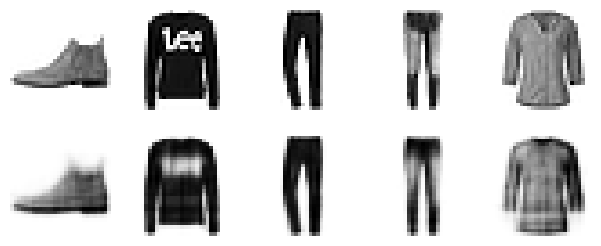

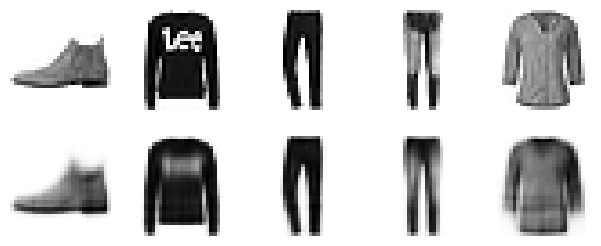

In [8]:
show_reconstructions(autoencoder, images = X_test)
show_reconstructions(RAE, images = X_test)

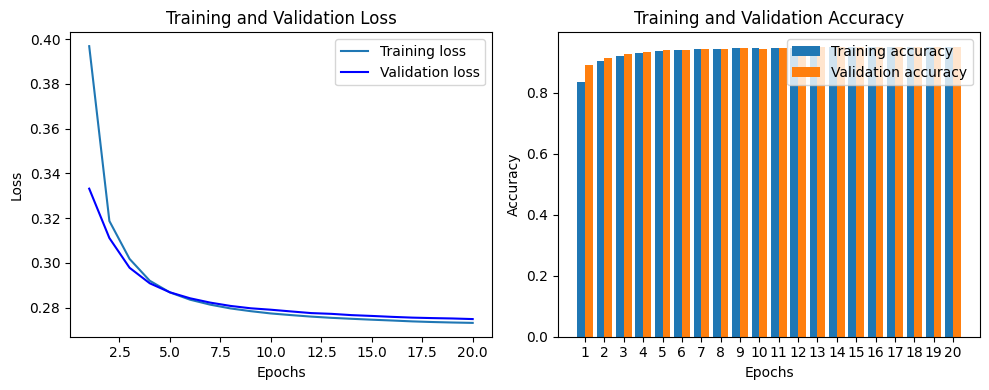

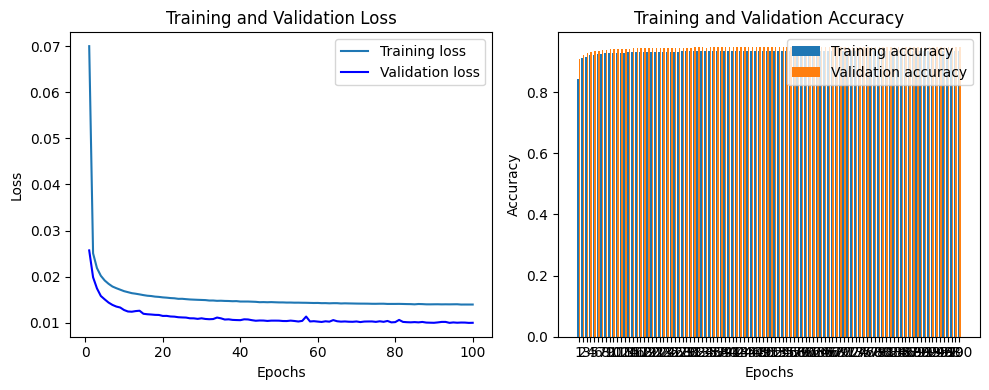

In [9]:
plot_history(history)
plot_history(history_RAE)

# STANDARD VARIATIONAL AUTOENCODER VS MODIFIED VARIATIONAL AUTOENCODER

In [10]:
def build_encoder(latent_dim):
    """Builds the encoder model for a VAE.

    Args:
        latent_dim (int): Dimension of the latent space.

    Returns:
        Model: The encoder model.
    """
    inputs = Input(shape=(28, 28, 1))  # Define the input with shape (28, 28, 1)
    
    # Stack convolutional layers with strides for downsampling and ReLU activation
    conv1 = Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu')(inputs)
    conv2 = Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu')(conv1)
    
    # Flatten the feature map and add a dense layer with ReLU activation
    flat = Flatten()(conv2)
    dense = Dense(units=latent_dim, activation='relu')(flat)
    
    # Separate dense layers for the mean and log variance of the latent space
    z_mean = Dense(units=latent_dim)(dense)
    z_log_var = Dense(units=latent_dim)(dense)
    
    # Create the encoder model
    encoder_model = Model(inputs=inputs, outputs=[z_mean, z_log_var], name='encoder')
    
    return encoder_model

def build_decoder(latent_dim):
    """Builds the decoder model for a VAE.

    Args:
        latent_dim (int): Dimension of the latent space.

    Returns:
        Model: The decoder model.
    """
    inputs = Input(shape=(latent_dim,))  # Define the input with the latent dimension
    
    # Dense layer to expand the latent space and reshape it back to the image dimensions
    dense = Dense(units=7*7*64, activation='relu')(inputs)
    reshaped = Reshape(target_shape=(7, 7, 64))(dense)
    
    # Stack Conv2DTranspose layers to upsample and reconstruct the image
    deconv1 = Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu')(reshaped)
    deconv2 = Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu')(deconv1)
    
    # Final Conv2DTranspose layer to produce the output image with sigmoid activation
    outputs = Conv2DTranspose(1, kernel_size=3, padding='same', activation='sigmoid')(deconv2)
    
    # Create the decoder model
    decoder_model = Model(inputs=inputs, outputs=outputs, name='decoder')
    
    return decoder_model

class VAE(Model):
    """Variational Autoencoder (VAE) model class.

    This class handles the forward pass and loss calculation for a VAE.
    """
    def __init__(self, encoder, decoder, **kwargs):
        """Initializes the VAE model with an encoder and a decoder.

        Args:
            encoder (Model): The encoder model.
            decoder (Model): The decoder model.
            **kwargs: Additional keyword arguments.
        """
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder  # Initialize the encoder
        self.decoder = decoder  # Initialize the decoder

    def call(self, inputs):
        """Performs the forward pass and computes the VAE loss.

        Args:
            inputs (Tensor): Input data.

        Returns:
            Tensor: The reconstructed output.
        """
        z_mean, z_log_var = self.encoder(inputs)  # Encode the input to obtain latent mean and log variance
        z = self.reparameterize(z_mean, z_log_var)  # Sample the latent vector using the reparameterization trick
        reconstructed = self.decoder(z)  # Decode the latent vector to reconstruct the input
        
        # Compute the reconstruction loss using binary crossentropy
        recon_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(inputs, tf.squeeze(reconstructed, axis=-1)))
        
        # Compute the KL divergence loss
        kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        
        # Combine the losses with a weighted sum
        total_loss = 0.7 * recon_loss + 0.3 * kl_loss
        self.add_loss(total_loss)  # Add the total loss to the model
        
        return reconstructed  # Return the reconstructed output

    def reparameterize(self, z_mean, z_log_var):
        """Applies the reparameterization trick to sample a latent vector.

        Args:
            z_mean (Tensor): Mean of the latent distribution.
            z_log_var (Tensor): Log variance of the latent distribution.

        Returns:
            Tensor: Sampled latent vector.
        """
        epsilon = tf.random.normal(shape=tf.shape(z_mean))  # Sample from a standard normal distribution
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon  # Compute the latent vector using the reparameterization trick

# Define the latent dimension
latent_dim = 64

# Build the encoder and decoder
encoder_model = build_encoder(latent_dim)
decoder_model = build_decoder(latent_dim)

# Create the VAE model
vae_model = VAE(encoder_model, decoder_model)

# Compile the VAE model
vae_model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.3),
                  loss='binary_crossentropy',
                  metrics=[rounded_accuracy])

# Train the VAE model
vae_history = vae_model.fit(X_train, X_train,  # Train using the same data for input and output
                            epochs=50,  # Number of training epochs
                            batch_size=128,  # Batch size
                            validation_data=(X_valid, X_valid),  # Validation data
                            verbose=1)  # Display training progress

Epoch 1/50
430/430 [==============================] - 10s 11ms/step - loss: 0.9441 - rounded_accuracy: 0.7137 - val_loss: 0.8075 - val_rounded_accuracy: 0.8226
Epoch 2/50
430/430 [==============================] - 4s 9ms/step - loss: 0.7321 - rounded_accuracy: 0.8248 - val_loss: 0.7598 - val_rounded_accuracy: 0.7831
Epoch 3/50
430/430 [==============================] - 4s 9ms/step - loss: 0.6703 - rounded_accuracy: 0.8605 - val_loss: 0.6592 - val_rounded_accuracy: 0.8720
Epoch 4/50
430/430 [==============================] - 4s 9ms/step - loss: 0.6495 - rounded_accuracy: 0.8712 - val_loss: 0.6371 - val_rounded_accuracy: 0.8804
Epoch 5/50
430/430 [==============================] - 4s 9ms/step - loss: 0.6364 - rounded_accuracy: 0.8775 - val_loss: 0.6292 - val_rounded_accuracy: 0.8835
Epoch 6/50
430/430 [==============================] - 4s 9ms/step - loss: 0.6266 - rounded_accuracy: 0.8816 - val_loss: 0.6249 - val_rounded_accuracy: 0.8867
Epoch 7/50
430/430 [==============================

In [11]:
def build_encoder_vae(latent_dim):
    """
    Builds the encoder part of the VAE with the specified latent dimension.
    
    Args:
        latent_dim (int): Dimension of the latent space.

    Returns:
        Model: Encoder model that outputs the mean and log variance of the latent distribution.
    """
    # Define the input shape for the encoder
    encoder_inputs = Input(shape=(28, 28, 1))
    
    # Apply a series of Conv2D layers with increasing filters, followed by BatchNormalization and LeakyReLU activation
    x = Conv2D(256, kernel_size=3, strides=2, padding='same')(encoder_inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(200, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    # Flatten the output from the last convolutional layer and apply a dense layer
    x = Flatten()(x)
    x = Dense(latent_dim, activation='relu', kernel_initializer="he_normal")(x)
    x = Dropout(0.2)(x)
    
    # Define the mean and log variance layers
    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)
    
    # Build and return the encoder model
    encoder = Model(encoder_inputs, [z_mean, z_log_var], name='encoder')
    return encoder


def build_decoder_vae(latent_dim):
    """
    Builds the decoder part of the VAE with the specified latent dimension.
    
    Args:
        latent_dim (int): Dimension of the latent space.

    Returns:
        Model: Decoder model that reconstructs the input from the latent space.
    """
    # Define the input shape for the decoder
    decoder_inputs = Input(shape=(latent_dim,))
    
    # Apply a dense layer followed by reshaping the output to match the input dimensions
    x = Dense(7*7*128, activation='relu', kernel_initializer="he_normal")(decoder_inputs)
    x = Reshape((7, 7, 128))(x)
    
    # Apply a series of Conv2DTranspose layers to upsample the image back to the original size
    x = Conv2DTranspose(128, kernel_size=3, activation='relu', strides=2, padding='same', kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    
    x = Conv2DTranspose(64, kernel_size=3, activation='relu', strides=2, padding='same', kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)
    
    # Final Conv2DTranspose layer to produce the output image
    x = Conv2DTranspose(1, kernel_size=3, activation='sigmoid', padding='same', kernel_initializer="he_normal")(x)
    
    # Reshape the output to match the input dimensions (28x28x1)
    decoder_outputs = Reshape((28, 28, 1))(x)
    
    # Build and return the decoder model
    decoder = Model(decoder_inputs, decoder_outputs, name='decoder')
    return decoder


class VAE(Model):
    """
    Variational Autoencoder (VAE) model that combines the encoder and decoder networks.
    
    Attributes:
        encoder (Model): Encoder model that encodes the input into a latent space.
        decoder (Model): Decoder model that decodes the latent space back to the input space.
        reconstruction_loss_tracker (tf.keras.metrics.Mean): Tracker for the reconstruction loss.
        kl_loss_tracker (tf.keras.metrics.Mean): Tracker for the KL divergence loss.
        total_loss_tracker (tf.keras.metrics.Mean): Tracker for the total loss.
        accuracy_tracker (tf.keras.metrics.Mean): Tracker for the rounded accuracy.
    """
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.accuracy_tracker = tf.keras.metrics.Mean(name="rounded_accuracy")

    def call(self, inputs):
        """
        Forward pass of the VAE. Encodes the input, reparameterizes it, and decodes it back to the input space.
        
        Args:
            inputs (Tensor): Input data.
        
        Returns:
            Tensor: Reconstructed output from the decoder.
        """
        z_mean, z_log_var = self.encoder(inputs)
        z = self.reparameterize(z_mean, z_log_var)
        reconstructed = self.decoder(z)
        return reconstructed

    @property
    def metrics(self):
        """
        Returns the list of metrics used to evaluate the model's performance.
        """
        return [self.reconstruction_loss_tracker, self.kl_loss_tracker, self.total_loss_tracker, self.accuracy_tracker]

    def train_step(self, data):
        """
        Custom training step for the VAE. Computes the total loss and updates the weights of the model.
        
        Args:
            data (tuple): A tuple containing the input data and labels.
        
        Returns:
            dict: Dictionary of metric names and their corresponding values.
        """
        inputs, _ = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(inputs)
            z = self.reparameterize(z_mean, z_log_var)
            reconstructed = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(inputs, reconstructed))
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = 0.7 * reconstruction_loss + 0.3 * kl_loss
            accuracy = rounded_accuracy(inputs, reconstructed)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.total_loss_tracker.update_state(total_loss)
        self.accuracy_tracker.update_state(accuracy)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """
        Custom testing step for the VAE. Computes the total loss and evaluates the model.
        
        Args:
            data (tuple): A tuple containing the input data and labels.
        
        Returns:
            dict: Dictionary of metric names and their corresponding values.
        """
        inputs, _ = data
        z_mean, z_log_var = self.encoder(inputs)
        z = self.reparameterize(z_mean, z_log_var)
        reconstructed = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(inputs, reconstructed))
        kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        total_loss = 0.8 * reconstruction_loss + 0.2 * kl_loss
        accuracy = rounded_accuracy(inputs, reconstructed)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.total_loss_tracker.update_state(total_loss)
        self.accuracy_tracker.update_state(accuracy)
        return {m.name: m.result() for m in self.metrics}

    def reparameterize(self, z_mean, z_log_var):
        """
        Reparameterizes the latent space using the mean and log variance.
        
        Args:
            z_mean (Tensor): Mean of the latent space.
            z_log_var (Tensor): Log variance of the latent space.
        
        Returns:
            Tensor: Reparameterized latent vector.
        """
        eps = tf.random.normal(shape=tf.shape(z_mean))
        return eps * tf.exp(z_log_var * 0.5) + z_mean


# Define the construction of the encoder and decoder
latent_dim = 70
encoder_vae = build_encoder_vae(latent_dim)
decoder_vae = build_decoder_vae(latent_dim)

# Create an instance of the VAE model using the encoder and decoder
MVAE = VAE(encoder_vae, decoder_vae)

# Compile the VAE with the Adam optimizer
MVAE.compile(optimizer='Adam')

# Train the VAE
history_MVAE = MVAE.fit(X_train.reshape(-1, 28, 28, 1), X_train.reshape(-1, 28, 28, 1),
                        epochs=80,  # Number of training epochs
                        batch_size=256,  # Batch size
                        validation_data=(X_valid.reshape(-1, 28, 28, 1), X_valid.reshape(-1, 28, 28, 1)),  # Validation data
                        verbose=1)  # Display training progress


Epoch 1/80
215/215 [==============================] - 23s 71ms/step - reconstruction_loss: 0.4653 - kl_loss: 0.0627 - total_loss: 0.3445 - rounded_accuracy: 0.7859 - val_reconstruction_loss: 0.3766 - val_kl_loss: 0.0867 - val_total_loss: 0.3186 - val_rounded_accuracy: 0.8528
Epoch 2/80
215/215 [==============================] - 13s 61ms/step - reconstruction_loss: 0.3632 - kl_loss: 0.0900 - total_loss: 0.2813 - rounded_accuracy: 0.8625 - val_reconstruction_loss: 0.3560 - val_kl_loss: 0.0930 - val_total_loss: 0.3034 - val_rounded_accuracy: 0.8697
Epoch 3/80
215/215 [==============================] - 13s 60ms/step - reconstruction_loss: 0.3506 - kl_loss: 0.0876 - total_loss: 0.2717 - rounded_accuracy: 0.8742 - val_reconstruction_loss: 0.3474 - val_kl_loss: 0.0913 - val_total_loss: 0.2962 - val_rounded_accuracy: 0.8793
Epoch 4/80
215/215 [==============================] - 13s 59ms/step - reconstruction_loss: 0.3435 - kl_loss: 0.0865 - total_loss: 0.2664 - rounded_accuracy: 0.8798 - val_re

1/1 [==============================] - 1s 580ms/step


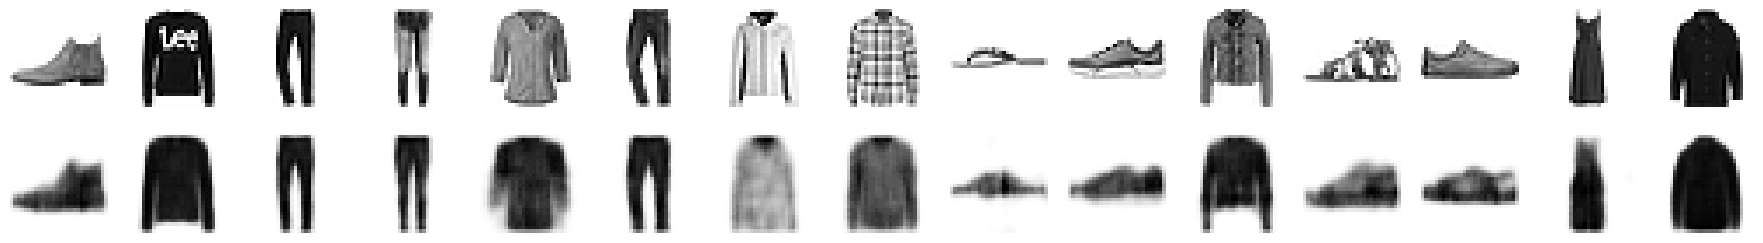

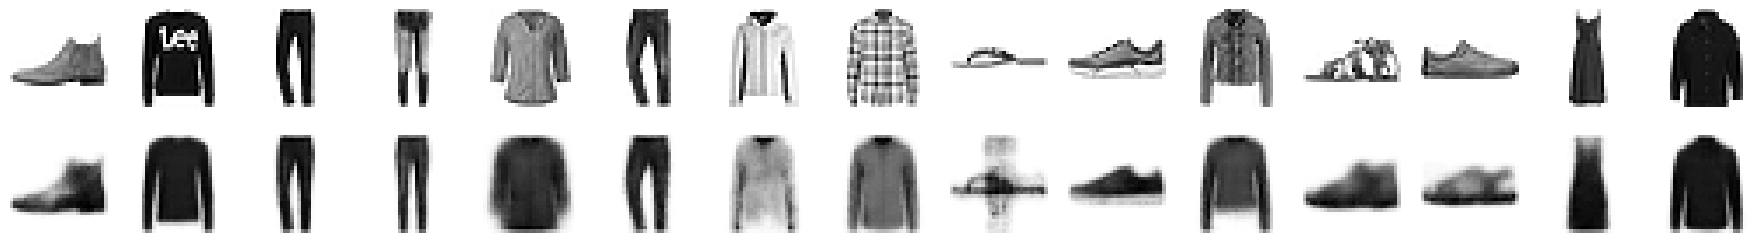

In [12]:
show_reconstructions(vae_model, images = X_test, n_images=15)
show_reconstructions(MVAE, images = X_test.reshape(-1, 28, 28, 1), n_images = 15)

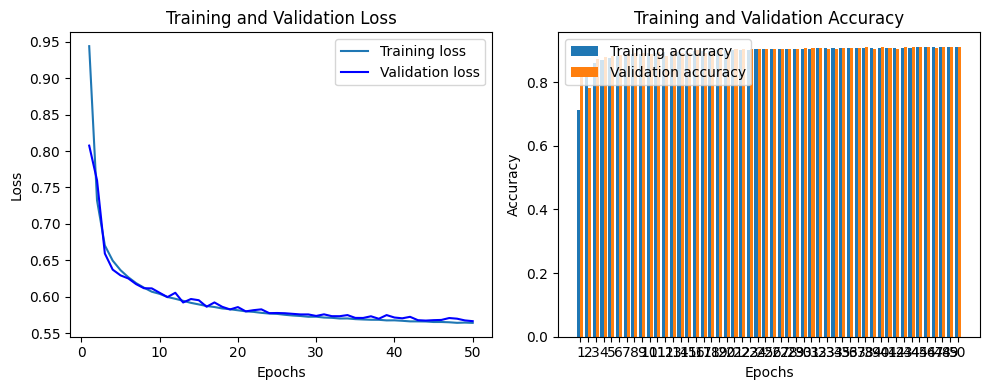

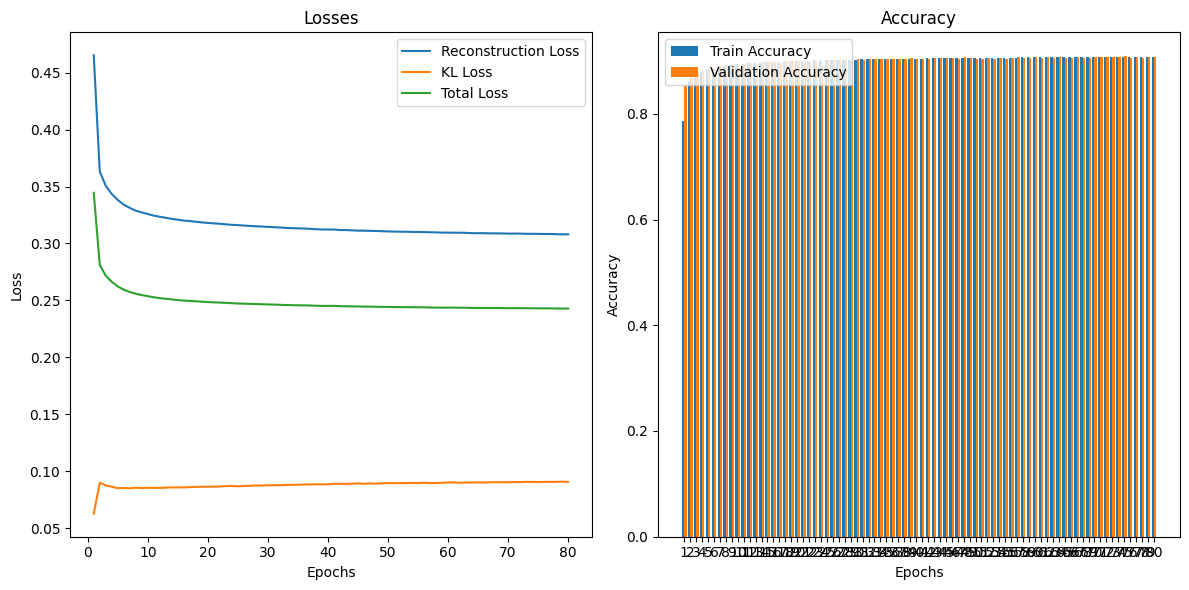

In [13]:
plot_history(vae_history)
plot_training_history(history_MVAE)

## GAN'S

Epoch 1/1
214/215

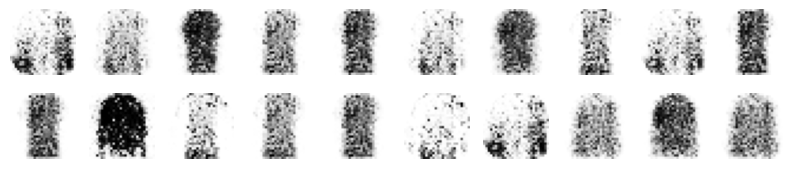

In [14]:
# Define the coding size (latent dimension) and batch size for training
codings_size = 30  # Latent vector size
batch_size = 256  # Batch size for training

# Build the generator model
generator = keras.models.Sequential([
    Input(shape=[codings_size]),  # Input layer with latent vector size
    Dense(100, activation="selu"),  # Dense layer with SELU activation
    Dense(150, activation="selu"),  # Another dense layer with SELU activation
    Dense(28 * 28, activation="sigmoid"),  # Output layer to produce a 28x28 image with sigmoid activation
    Reshape([28, 28])  # Reshape the output to 28x28 format
])

# Build the discriminator model
discriminator = keras.models.Sequential([
    Input(shape=[28, 28]),  # Input layer with 28x28 images
    Flatten(),  # Flatten the input image into a vector
    Dense(150, activation="selu"),  # Dense layer with SELU activation
    Dense(100, activation="selu"),  # Another dense layer with SELU activation
    Dense(1, activation="sigmoid")  # Output layer to produce a probability with sigmoid activation
])

# Combine the generator and discriminator to form the GAN model
gan = keras.models.Sequential([generator, discriminator])

# Compile the discriminator model
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")  # Compile with binary crossentropy loss and RMSprop optimizer
discriminator.trainable = False  # Freeze the discriminator's weights during GAN training

# Compile the GAN model
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")  # Compile the GAN with binary crossentropy loss and RMSprop optimizer

# Create a TensorFlow dataset from X_train, reshaping the images to (28, 28)
dataset = tf.data.Dataset.from_tensor_slices(np.reshape(X_train, (X_train.shape[0], 28, 28)))
dataset = dataset.shuffle(1000)  # Shuffle the dataset with a buffer of 1000 elements

# Batch the dataset and prefetch to improve performance
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

# Train the GAN using the defined dataset, batch size, coding size, and number of epochs
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

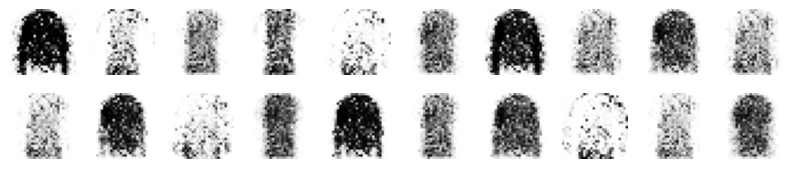

In [15]:
# Generate a batch of random noise vectors with the defined batch size and coding size
noise = tf.random.normal(shape=[batch_size, codings_size])

# Generate images from the random noise using the generator model
generated_images = generator(noise)

# Plot the first 20 generated images in a grid with 10 columns
plot_multiple_images(generated_images[:20], 10)

In [16]:
codings_size = 30 # Tamaño del vector de codificación para el ruido de entrada al generador
batch_size = 64 # Configuración del tamaño del lote y preparación del dataset


# Generador mejorado
generator = keras.models.Sequential([
    Input(shape=[codings_size]),  # Entrada del generador con tamaño codings_size
    Dense(7*7*128, activation="selu"),  # Capa densa con activación SELU
    Reshape([7, 7, 128]),  # Reforma la salida a forma 7x7x128
    BatchNormalization(),  # Normalización por lotes para estabilizar el entrenamiento
    Conv2DTranspose(256, kernel_size=5, strides=2, padding='same', activation='selu'),  # Capa de convolución transpuesta
    BatchNormalization(),  # Normalización por lotes
    Conv2DTranspose(32, kernel_size=5, strides=2, padding='same', activation='selu'),  # Otra capa de convolución transpuesta
    BatchNormalization(),  # Normalización por lotes
    Conv2DTranspose(1, kernel_size=5, strides=1, padding='same', activation='sigmoid')  # Capa final para generar la imagen con activación sigmoidal
])

# Discriminador mejorado
discriminator = keras.models.Sequential([
    Input(shape=[28, 28, 1]),  # Entrada del discriminador con imágenes de tamaño 28x28 y un canal
    Conv2D(32, kernel_size=5, strides=2, padding='same', activation='selu'),  # Capa convolucional
    BatchNormalization(),  # Normalización por lotes
    Conv2D(64, kernel_size=5, strides=2, padding='same', activation='selu'),  # Otra capa convolucional
    BatchNormalization(),  # Normalización por lotes
    Conv2D(256, kernel_size=5, strides=2, padding='same', activation='selu'),  # Capa convolucional final
    BatchNormalization(),  # Normalización por lotes
    Dropout(0.2),  # Dropout para evitar el sobreajuste
    Flatten(),  # Aplana el tensor para la capa densa final
    Dense(1, activation='sigmoid')  # Capa densa final con activación sigmoidal para la clasificación binaria
])

# Modelo GAN combinado
gan = keras.models.Sequential([generator, discriminator])

# Compilar el discriminador
discriminator.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))
discriminator.trainable = False  # Congelar el discriminador durante el entrenamiento del GAN

# Compilar el modelo GAN
gan.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5))

dataset = tf.data.Dataset.from_tensor_slices(np.reshape(X_train, (X_train.shape[0], 28, 28))).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epoch 1/10
1/859

2024-08-12 02:04:43.332346: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


859/859

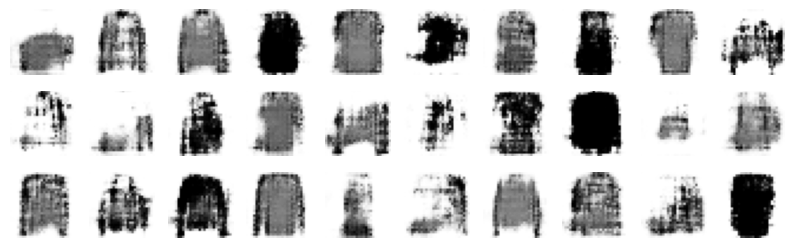

Epoch 2/10
859/859

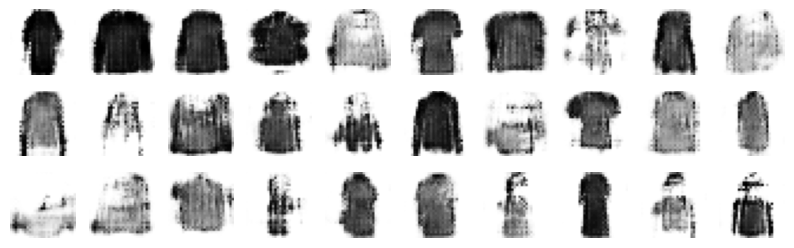

Epoch 3/10
859/859

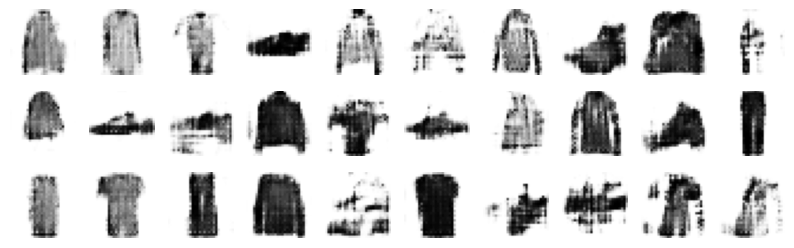

Epoch 4/10
859/859

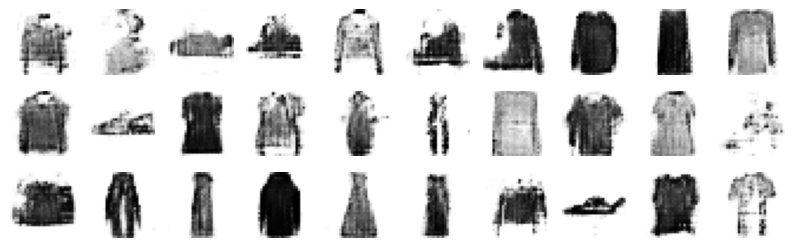

Epoch 5/10
859/859

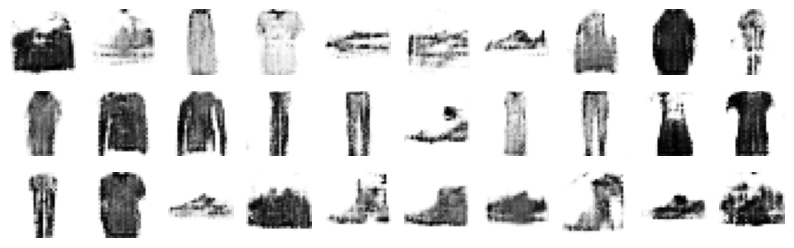

Epoch 6/10
859/859

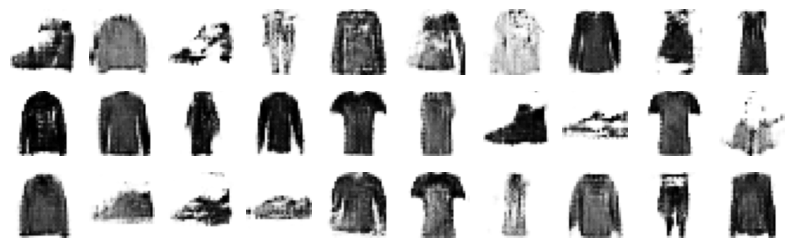

Epoch 7/10
859/859

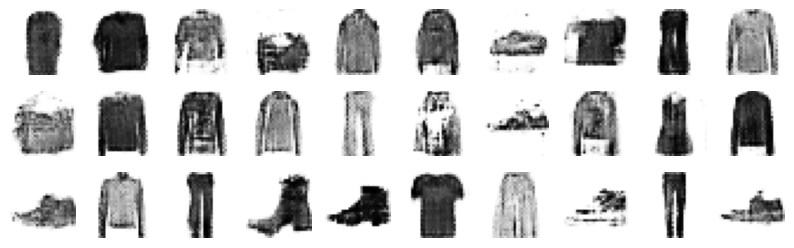

Epoch 8/10
859/859

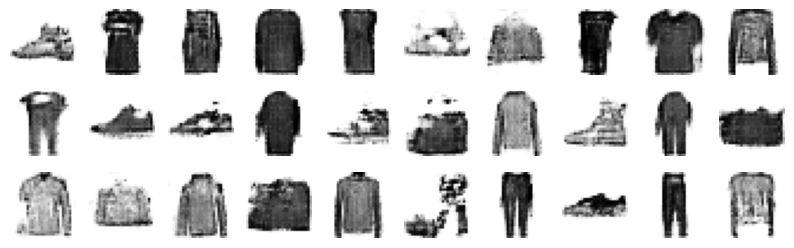

Epoch 9/10
859/859

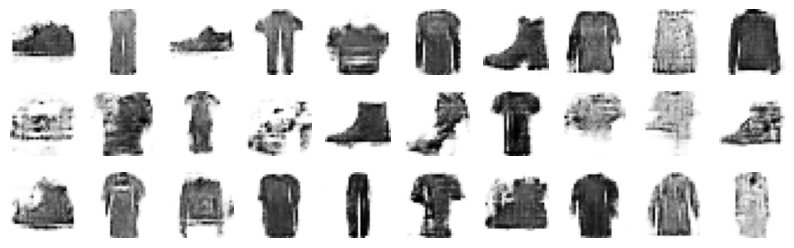

Epoch 10/10
859/859

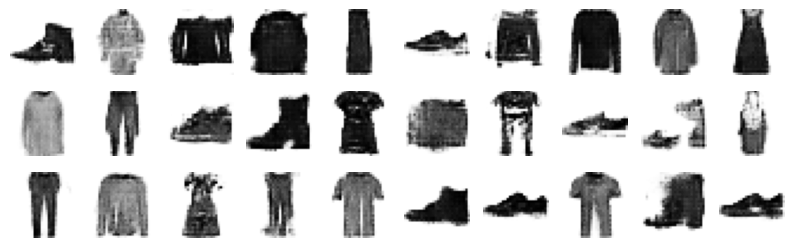

In [17]:
train_gan_M(gan, dataset, batch_size, codings_size, n_epochs=10)

## CAM'S

In [ ]:
def build_encoder_with_classifier(latent_dim, num_classes):
    """
    Build an encoder model with a classifier for the VAE.
    
    Args:
    latent_dim (int): Dimension of the latent space.
    num_classes (int): Number of classes for classification.
    
    Returns:
    keras.models.Model: The encoder model with classification head.
    """
    # Define the input layer for the encoder
    inputs = Input(shape=(28, 28, 1))

    # Convolutional layers for feature extraction
    x = Conv2D(256, 3, strides=2, padding='same', name='conv_1')(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(200, 3, strides=2, padding='same', name='conv_2')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(128, 3, strides=2, padding='same', name='conv_3')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    # Flatten and dense layer to obtain latent space variables
    x = Flatten()(x)
    x = Dense(latent_dim, activation='relu', kernel_initializer="he_normal")(x)
    x = Dropout(0.2)(x)

    # Classification layer
    classifier_output = Dense(num_classes, activation='softmax', name='classifier')(x)

    # Dense layers for latent space variables
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    # Define the full encoder model
    encoder = Model(inputs, [z_mean, z_log_var, classifier_output], name='encoder')
    return encoder

def build_decoder(latent_dim):
    """
    Build a decoder model for the VAE.
    
    Args:
    latent_dim (int): Dimension of the latent space.
    
    Returns:
    keras.models.Model: The decoder model.
    """
    # Define the input layer for the decoder
    inputs = Input(shape=(latent_dim,))

    # Dense and transposed convolutional layers to reconstruct the image
    x = Dense(7*7*128, activation='relu', kernel_initializer="he_normal")(inputs)
    x = Reshape((7, 7, 128))(x)

    x = Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same', kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)

    x = Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same', kernel_initializer="he_normal")(x)
    x = BatchNormalization()(x)

    x = Conv2DTranspose(1, 3, activation='sigmoid', padding='same', kernel_initializer="he_normal", name='final')(x)
    outputs = Reshape((28, 28, 1))(x)

    # Define the full decoder model
    decoder = Model(inputs, outputs, name='decoder')
    return decoder

class VAEWithClassifier(Model):
    """
    VAE model with classifier for classification tasks.
    """
    def __init__(self, encoder, decoder, **kwargs):
        super(VAEWithClassifier, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

    def call(self, inputs):
        """
        Forward pass through the VAE model.
        
        Args:
        inputs (tf.Tensor): Input tensor for the model.
        
        Returns:
        tuple: z_mean, z_log_var, y_pred, X_reconstructed
        """
        # Encoder forward pass to get latent variables and classifier predictions
        z_mean, z_log_var, y_pred = self.encoder(inputs)
        # Reparameterize to obtain z
        z = self.reparameterize(z_mean, z_log_var)
        # Decoder forward pass to reconstruct the image
        X_reconstructed = self.decoder(z)
        return z_mean, z_log_var, y_pred, X_reconstructed

    def train_step(self, data):
        """
        Training step for the VAE model.
        
        Args:
        data (tuple): Tuple of (input, label) tensors.
        
        Returns:
        dict: Dictionary of loss and accuracy metrics.
        """
        X, y = data

        with tf.GradientTape() as tape:
            # Forward pass
            z_mean, z_log_var, y_pred, X_reconstructed = self(X, training=True)
            # Compute custom loss
            loss = self.custom_loss(y, y_pred, z_mean, z_log_var, X, X_reconstructed)

        # Compute gradients and apply optimization
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # Update metrics
        self.accuracy_metric.update_state(y, y_pred)

        # Collect results
        results = {m.name: m.result() for m in self.metrics}
        results['loss'] = loss
        results['accuracy'] = self.accuracy_metric.result()
        return results

    def test_step(self, data):
        """
        Test step for the VAE model.
        
        Args:
        data (tuple): Tuple of (input, label) tensors.
        
        Returns:
        dict: Dictionary of loss and accuracy metrics.
        """
        X, y = data

        # Forward pass (evaluation mode)
        z_mean, z_log_var, y_pred, X_reconstructed = self(X, training=False)

        # Compute custom loss
        loss = self.custom_loss(y, y_pred, z_mean, z_log_var, X, X_reconstructed)

        # Update metrics
        self.accuracy_metric.update_state(y, y_pred)

        # Collect results
        results = {m.name: m.result() for m in self.metrics}
        results['loss'] = loss
        results['accuracy'] = self.accuracy_metric.result()
        return results

    def custom_loss(self, y_true, y_pred, z_mean, z_log_var, X_true, X_reconstructed):
        """
        Compute custom loss for the VAE model.
        
        Args:
        y_true (tf.Tensor): True labels.
        y_pred (tf.Tensor): Predicted labels.
        z_mean (tf.Tensor): Mean of the latent space.
        z_log_var (tf.Tensor): Log variance of the latent space.
        X_true (tf.Tensor): True images.
        X_reconstructed (tf.Tensor): Reconstructed images.
        
        Returns:
        tf.Tensor: Total loss.
        """
        # Reconstruction loss
        reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(X_true, X_reconstructed))
        reconstruction_loss *= 28 * 28

        # KL divergence loss
        kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))

        # Classification loss
        classification_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true=y_true, y_pred=y_pred)
        classification_loss = tf.reduce_mean(classification_loss)

        # Total loss
        total_loss = reconstruction_loss + kl_loss + classification_loss
        return total_loss

    def reparameterize(self, z_mean, z_log_var):
        """
        Reparameterization trick to sample z.
        
        Args:
        z_mean (tf.Tensor): Mean of the latent space.
        z_log_var (tf.Tensor): Log variance of the latent space.
        
        Returns:
        tf.Tensor: Sampled latent vector z.
        """
        eps = tf.random.normal(shape=tf.shape(z_mean))
        return eps * tf.exp(z_log_var * 0.5) + z_mean

# Parameters for the VAE model
LATENT_DIM = 70
NUM_CLASSES = 10

# Build encoder and decoder models
encoder_with_classifier = build_encoder_with_classifier(LATENT_DIM, NUM_CLASSES)
decoder = build_decoder(LATENT_DIM)

# Define and compile the VAE model with classifier
vae_with_classifier = VAEWithClassifier(encoder_with_classifier, decoder)
vae_with_classifier.compile(optimizer='Adam', metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

# Setup early stopping callback
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=30)

# Train the VAE model with classifier
history = vae_with_classifier.fit(
    X_train.reshape(-1, 28, 28, 1),
    y_train,
    epochs=100,
    batch_size=256,
    validation_data=(X_valid.reshape(-1, 28, 28, 1), y_valid),
    callbacks=[early_stopping_callback],
    verbose=0
)


Epoch 1/200
215/215 [==============================] - 17s 58ms/step - accuracy: 0.3577 - loss: 711752.8577 - val_accuracy: 0.3430 - val_loss: 1151.8444
Epoch 2/200
215/215 [==============================] - 12s 57ms/step - accuracy: 0.5704 - loss: 274.1325 - val_accuracy: 0.4940 - val_loss: 1477.1396
Epoch 3/200
215/215 [==============================] - 12s 58ms/step - accuracy: 0.6470 - loss: 262.1628 - val_accuracy: 0.7168 - val_loss: 1444.8729
Epoch 4/200
215/215 [==============================] - 12s 57ms/step - accuracy: 0.6727 - loss: 256.3309 - val_accuracy: 0.7364 - val_loss: 1157.4788
Epoch 5/200
215/215 [==============================] - 12s 56ms/step - accuracy: 0.6907 - loss: 252.3185 - val_accuracy: 0.7418 - val_loss: 597.9020
Epoch 6/200
215/215 [==============================] - 12s 56ms/step - accuracy: 0.7052 - loss: 249.2294 - val_accuracy: 0.7598 - val_loss: 286.7522
Epoch 7/200
215/215 [==============================] - 12s 56ms/step - accuracy: 0.7170 - loss: 247

In [ ]:
import matplotlib.pyplot as plt

def plot_images_and_reconstructions(X_test, vae_model, n_images=20):
    """
    Display original images and their reconstructions from a VAE model.
    
    Args:
    X_test (np.ndarray): Array of test images.
    vae_model (tf.keras.Model): Trained VAE model used for image reconstruction.
    n_images (int): Number of images to display. Default is 20.
    """
    # Select the first n_images from the test set
    images = X_test[:n_images]
    
    # Predict reconstructions using the VAE model
    reconstructions = vae_model.predict(images.reshape(-1, 28, 28, 1))[-1]
    
    # Select only the first channel of the reconstructions (in case of RGB images)
    reconstructions = reconstructions[:, :, :, 0]

    # Set up the figure for displaying original and reconstructed images
    fig = plt.figure(figsize=(n_images * 1.5, 3))

    # Loop through each image to display it along with its reconstruction
    for i in range(n_images):
        # Original image
        original_image = images[i].reshape(28, 28)
        plt.subplot(2, n_images, i + 1)  # Position in the first row
        plot_image(original_image)  # Function to display the image
        
        # Reconstructed image
        reconstructed_image = reconstructions[i].reshape(28, 28)
        plt.subplot(2, n_images, n_images + i + 1)  # Position in the second row
        plot_image(reconstructed_image)  # Function to display the image

    plt.show()

def plot_image(image):
    """
    Plot a single image.
    
    Args:
    image (np.ndarray): Image array to plot.
    """
    plt.imshow(image, cmap='gray')
    plt.axis('off')

# Example usage
plot_images_and_reconstructions(X_test, vae_with_classifier)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from gradcam_plus_plus import GradcamPlusPlus
from gradcam_plus_plus import ReplaceToLinear, CategoricalScore

def plot_cam(layer_name, image, class_label, ax, max_value):
    """
    Plot the GradCAM++ heatmap for a given layer, image, and class label.
    
    Args:
    layer_name (str): Name of the layer for which GradCAM++ is computed.
    image (np.ndarray): Input image for generating the CAM.
    class_label (int): Class label for which GradCAM++ is computed.
    ax (matplotlib.axes.Axes): Axes object for plotting.
    max_value (float): Maximum value for normalizing the CAM heatmap.
    
    Returns:
    matplotlib.image.AxesImage: The heatmap image.
    """
    # Create a model for GradCAM++ that outputs the classifier layer
    model_for_gradcam = Model(inputs=encoder_with_classifier.input,
                              outputs=encoder_with_classifier.get_layer('classifier').output)
    
    # Initialize GradCAM++ object
    gradcam = GradcamPlusPlus(model_for_gradcam, model_modifier=ReplaceToLinear(), clone=True)

    # Generate the CAM using GradCAM++
    cam = gradcam(CategoricalScore(class_label), image.reshape(1, 28, 28, 1),
                  penultimate_layer=layer_name, normalize_cam=False)
    
    # Compute the mean of the CAM values
    cam_mean = np.mean(cam[0])
    
    # Plot the original image and the CAM
    ax.imshow(image.squeeze(), cmap='gray')
    heatmap = ax.imshow(cam[0], cmap='jet', alpha=0.5, vmin=0, vmax=max_value)
    ax.set_title(f'Mean: {cam_mean:.2f}')
    ax.axis('off')
    
    return heatmap

# Layers to analyze
layers = ['conv_1', 'conv_2', 'conv_3']

# Create a model for GradCAM++ that outputs the classifier layer
model_for_gradcam = Model(inputs=encoder_with_classifier.input,
                          outputs=encoder_with_classifier.get_layer('classifier').output)

# Initialize GradCAM++ object
gradcam = GradcamPlusPlus(model_for_gradcam, model_modifier=ReplaceToLinear(), clone=True)

# Iterate over each layer
for layer in layers:
    print('Analyzing layer:', layer)
    
    # Iterate over each class
    for class_label in range(10):
        # Find the index of the first image in the test set with the given class label
        index = np.where(y_test == class_label)[0][0]
        
        # Create a figure with subplots for displaying images and heatmaps
        fig, axes = plt.subplots(1, 10, figsize=(20, 2))
        
        # Calculate the maximum CAM value for normalization
        cams = [gradcam(CategoricalScore(j), X_test[index].reshape(1, 28, 28, 1),
                        penultimate_layer=layer, normalize_cam=False)[0] for j in range(10)]
        max_val = np.max(cams)

        heatmaps = []
        # Plot CAM for each class
        for j in range(10):
            ax = axes[j]
            heatmap = plot_cam(layer, X_test[index], j, ax, max_val)
            heatmaps.append(heatmap)

        # Add a common colorbar for the row
        fig.colorbar(heatmaps[0], ax=axes, orientation='vertical', fraction=0.02, pad=0.04)

        plt.show()

In [ ]:
# Define class labels (0 to 9)
classes = range(10)

# Initialize lists for correct and incorrect predictions
correct_predictions = [0] * 10
incorrect_predictions = [0] * 10

# Predict labels for the test set
y_pred = np.argmax(model_for_gradcam.predict(X_test), axis=1)

# Calculate the number of correct and incorrect predictions for each class
for true_label, pred_label in zip(y_test, y_pred):
    if true_label == pred_label:
        correct_predictions[true_label] += 1
    else:
        incorrect_predictions[true_label] += 1

# Define bar width and x positions
bar_width = 0.35
x_positions = np.arange(len(classes))

# Create the bar plot
fig, ax = plt.subplots()
bars_correct = ax.bar(x_positions - bar_width/2, correct_predictions, bar_width, label='Correct', color='green')
bars_incorrect = ax.bar(x_positions + bar_width/2, incorrect_predictions, bar_width, label='Incorrect', color='red')

# Add labels and title
ax.set_xlabel('Classes')
ax.set_ylabel('Count')
ax.set_title('Correct and Incorrect Predictions by Class')
ax.set_xticks(x_positions)
ax.set_xticklabels(classes)
ax.legend()

# Show the plot
plt.show()

In [ ]:
# Get latent projections from the VAE encoder
z_mean, z_log_var, _ = vae_with_classifier.encoder.predict(X_test.reshape(-1, 28, 28, 1))

# Use t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z_2d = tsne.fit_transform(z_mean)

# Plot the 2D latent projections
plt.figure(figsize=(8, 5))

# Scatter plot of the 2D projections with color mapping based on class labels
scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=y_test, cmap='tab10')

# Add a color bar to indicate class labels
plt.colorbar(scatter)

# Set plot labels and title
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of Latent Space')

# Show the plot
plt.show()


In [ ]:
def visualize_with_images(z_2d, images, labels, image_size=(28, 28), zoom=0.6):
    """
    Visualizes 2D latent space projections with corresponding images.

    Args:
        z_2d (numpy.ndarray): 2D projections of the latent space.
        images (numpy.ndarray): Original images corresponding to the projections.
        labels (numpy.ndarray): Labels for the images.
        image_size (tuple): Size of the images to be displayed (default is (28, 28)).
        zoom (float): Zoom factor for the images in the plot (default is 0.6).
    """
    plt.figure(figsize=(10, 8))  # Set the figure size
    cmap = plt.cm.tab10  # Color map for class labels

    # Scatter plot of the 2D latent projections with color mapping based on labels
    scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=labels, cmap=cmap, s=10)
    plt.colorbar(scatter)  # Add a color bar for class labels

    # Initialize positions for image annotation
    image_positions = np.array([[1., 1.]])
    for index, position in enumerate(z_2d):
        # Calculate distances from the current position to previously annotated positions
        dist = np.sum((position - image_positions) ** 2, axis=1)
        if np.min(dist) > 0.01:  # If the position is sufficiently distant from others
            image_positions = np.r_[image_positions, [position]]  # Update positions

            # Create an annotation box for the image
            imagebox = AnnotationBbox(
                OffsetImage(np.reshape(images[index], image_size), cmap="gray", zoom=zoom),
                position, bboxprops={"edgecolor": cmap(labels[index]), "lw": 2}
            )
            plt.gca().add_artist(imagebox)  # Add image annotation to the plot

    plt.axis("off")  # Turn off axis
    plt.show()  # Display the plot

# Visualize the 2D latent space with images
visualize_with_images(z_2d, X_test, y_test)
